# Neural Network for Sentiment Analysis on Book Reviews

In [345]:
import pandas as pd
import numpy as np
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress info and warning messages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import tensorflow.keras as keras
import time

In [346]:
filename = os.path.join(os.getcwd(), "data", "bookReviews.csv")
df = pd.read_csv(filename, header=0)

In [347]:
# Inspect data
print(df.shape)
print(df.columns)
print(df.head(10))

(1973, 2)
Index(['Review', 'Positive Review'], dtype='object')
                                              Review  Positive Review
0  This was perhaps the best of Johannes Steinhof...             True
1  This very fascinating book is a story written ...             True
2  The four tales in this collection are beautifu...             True
3  The book contained more profanity than I expec...            False
4  We have now entered a second time of deep conc...             True
5  I don't know why it won the National Book Awar...            False
6  The daughter of a prominent Boston doctor is d...            False
7  I was very disapointed in the book.Basicly the...            False
8  I think in retrospect I wasted my time on this...            False
9  I have a hard time understanding what it is th...            False


In [348]:
# Create labels
y = df["Positive Review"]
X = df["Review"]

In [349]:
# Create training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

#### Implement TF-IDF Vectorizer to Transform Text

In [350]:
# TfidfVectorizer object 
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer to X_train
tfidf_vectorizer.fit(X_train)

# Using the fitted vectorizer, transform the training data 
X_train_tfidf = tfidf_vectorizer.transform(X_train)

# Using the fitted vectorizer, transform the test data 
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [351]:
vocabulary_size = len(tfidf_vectorizer.vocabulary_)

print(vocabulary_size)

18484


#### Construct a Neural Network


In [352]:
# Create model object
nn_model = keras.Sequential()

# Create the input layer
input_layer = keras.layers.InputLayer(input_shape=(vocabulary_size,))
nn_model.add(input_layer)

# Create the first hidden layer
layer1 = keras.layers.Dense(units=64, activation="relu")
nn_model.add(keras.layers.Dropout(.25))
nn_model.add(layer1)

# Create the second layer 
layer2 = keras.layers.Dense(units=32, activation="relu")
nn_model.add(keras.layers.Dropout(.25))
nn_model.add(layer2)

# Create the third layer 
layer3 = keras.layers.Dense(units=16, activation="relu")
nn_model.add(keras.layers.Dropout(.25))
nn_model.add(layer3)

# Create the output layer 
output = keras.layers.Dense(units=1, activation="sigmoid")
nn_model.add(output)

# Print summary of neural network model structure
nn_model.summary()

C:\Users\sophi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_63 (Dropout)            │ (None, 18484)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 64)             │     1,183,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185,665 (4.52 MB)

 Trainable params: 1,185,665 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

In [353]:
# Optimization function
sgd_optimizer = keras.optimizers.SGD(learning_rate = 0.5)

In [354]:
# Loss function
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

In [355]:
# Compile model
nn_model.compile(optimizer = sgd_optimizer, loss = loss_fn, metrics=["accuracy"])

In [356]:
class ProgBarLoggerNEpochs(keras.callbacks.Callback):
    
    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                      for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))


In [357]:
t0 = time.time() # start time

num_epochs = 40 # epochs

history = nn_model.fit(X_train_tfidf.toarray(), y_train, epochs=num_epochs, verbose=0, validation_split=0.2, callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=5)])

t1 = time.time() # stop time

print('Elapsed time: %.2fs' % (t1-t0))

Epoch [5/ 40], Accuracy: 0.5934, Loss: 0.6745, Val_accuracy: 0.5777, Val_loss: 0.6580
Epoch [10/ 40], Accuracy: 0.6948, Loss: 0.6264, Val_accuracy: 0.7331, Val_loss: 0.6042
Epoch [15/ 40], Accuracy: 0.7253, Loss: 0.5724, Val_accuracy: 0.4966, Val_loss: 0.9556
Epoch [20/ 40], Accuracy: 0.8098, Loss: 0.4448, Val_accuracy: 0.8074, Val_loss: 0.4480
Epoch [25/ 40], Accuracy: 0.8639, Loss: 0.3279, Val_accuracy: 0.7905, Val_loss: 0.4825
Epoch [30/ 40], Accuracy: 0.8047, Loss: 0.4663, Val_accuracy: 0.7872, Val_loss: 0.5322
Epoch [35/ 40], Accuracy: 0.8521, Loss: 0.3745, Val_accuracy: 0.7973, Val_loss: 0.5489
Epoch [40/ 40], Accuracy: 0.9501, Loss: 0.1889, Val_accuracy: 0.8007, Val_loss: 0.4904
Elapsed time: 6.88s


In [358]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

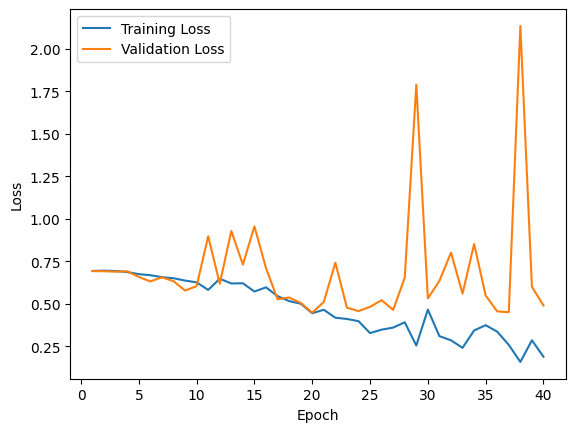

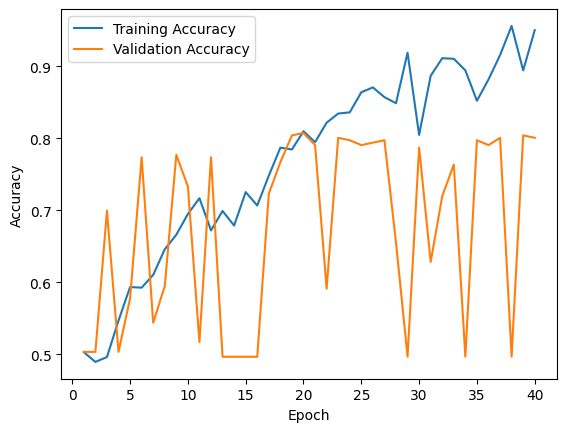

In [359]:
# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### Evaluate the Model's Performance

In [360]:
loss, accuracy = nn_model.evaluate(X_test_tfidf.toarray(), y_test)

print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8164 - loss: 0.4567
Loss:  0.46973881125450134 Accuracy:  0.8178137540817261


#### Make Predictions on the Test Set

In [361]:
# Make predictions on the test set
probability_predictions = nn_model.predict(X_test_tfidf.toarray())

print("Predictions for the first 20 examples:")
# YOUR CODE HERE
for i in range(20):
    probability = probability_predictions[i]
    if probability > 0.5:
        print(str(probability) + " : " + str(y_test.to_numpy()[i]))
    

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Predictions for the first 20 examples:
[0.80900913] : True
[0.90471196] : True
[0.8479182] : True
[0.54584104] : False
[0.8733108] : True
[0.8737261] : True
[0.8841238] : True
[0.68607396] : True
[0.8786202] : True
[0.71654844] : False
[0.8723465] : True


In [362]:
# Check a few of the original book review texts to get a further glimpse into how the model is performing.
print('Review #1:\n')

print(X_test.to_numpy()[11])

goodReview = True if probability_predictions[11] >= .5 else False
    
print('\nPrediction: Is this a good review? {}\n'.format(goodReview))

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[11]))

Review #1:

I was wrong. Ok, I've admitted it. I always thought science fiction or futuristic type novels weren't my cup of tea. While reading Conspiracy in Death I realized I couldn't have been more wrong - I love this futuristic series! 

A homeless man is murdered and the case is assigned to Eve Dallas, since it's not a random act of violence. This man, Snooks, died when his heart was surgically removed by what appeared to be a very skilled surgeon. When Dallas digs a bit further, she discovers that this crime is connected to another committed in New York City where an aged LC (licensed companion) died as the result of her liver being removed. After even more digging, Dallas discovers a case in Chicago and one abroad that were all similar. 

These were not the result of black market organ sales since all of the victims were within a few months of dying. In order for Eve Dallas to find the murderer she had to figure out why these victims were chosen. The closer she got to that answer

In [363]:
print('Review #2:\n')

print(X_test.to_numpy()[24])

goodReview = True if probability_predictions[24] >= .5 else False

print('\nPrediction: Is this a good review? {}\n'.format(goodReview)) 

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[24]))

Review #2:

Good book on deal structure, but if you want a valuation number, check out &quot;Unlocking the Value of Your Business&quot;


Prediction: Is this a good review? True

Actual: Is this a good review? False



In [364]:
print('Review #3:\n')

print(X_test.to_numpy()[56])

goodReview = True if probability_predictions[56] >= .5 else False
    
print('\nPrediction: Is this a good review? {}\n'.format(goodReview))

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[56]))

Review #3:

I'm trying to figure out what the appropriate subtitle for this book should be and I can't decide among the following:

    * Travels Through Guilt with the World's 33rd Richest Hippie
    * The Mind of an Empty Suit
    * A Self-Important Revisionist History
    * How I Learned to Hate Myself and Love the Third World
    * Memoirs of a Cold War Paperpusher

Confessions of an Economic Hitman by John Perkins is an exclamation point riddled history of a few financial manipulations of the Cold War by a man who had no stake in his own ambition.

The first thing you notice about this account is that it is written by a man who thinks he was sitting on top of the world, when in fact he was just a cog in the energy industry. If you are credulous enough to believe that the debts and revenues associated with the energy business is indeed the core principle of the global economy, then the moral outrage of this book makes sense. But there's a whole lot to swallow.

On the plus side, it

In [365]:
print('Review #4:\n')
print(X_test.to_numpy()[102])

goodReview = True if probability_predictions[102] >= .5 else False
    
print('\nPrediction: Is this a good review? {}\n'.format(goodReview))

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[102]))

Review #4:

I'm a Zone diet believer - but this book is a serious letdown.  Two major problems with this worthless book:
1. Almost all of the recipes involve *far* too much preparation - the title is *very* misleading.
2. I find it hard to believe that anyone actually prepared these recipes, and thought they were *good*!  Most of the meals are horrible due to the *huge* proportion of vegetables.  I mean, an omelet with over 3 cups of asparagus??


Prediction: Is this a good review? False

Actual: Is this a good review? False



In [366]:
# Get the predicted probabilities
y_pred_prob = probability_predictions

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score: ", roc_auc)

ROC AUC Score:  0.9114098360655738


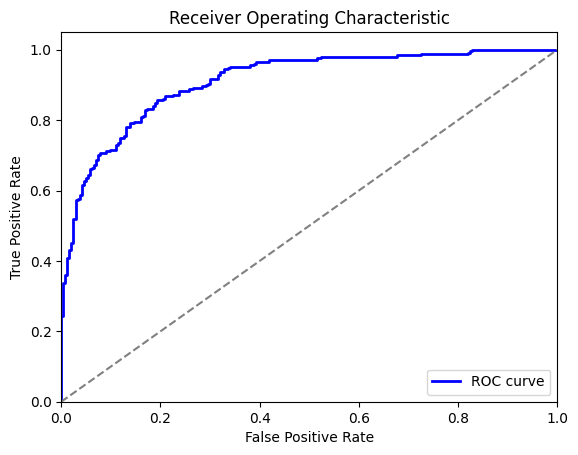

In [367]:
# Get false positive rates, true positive rates, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probability_predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
